In [1]:
# see https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# maybe look at this??? https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir_w6 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/"
# Load dataset

train_embeddings = np.load(input_dir_w6+'scBaseEncoderFeat_Z_bs250_tau0.5.npy')
print(train_embeddings.shape)

(41093, 5)


In [4]:
input_dir_w5 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/"

adata_train = ad.read_h5ad(input_dir_w5+'Larry_41093_2000_norm_log_cleaned.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)

(41093,)


In [5]:
adata_train

AnnData object with n_obs × n_vars = 41093 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb'
    layers: 'raw_counts'

In [6]:
# Assuming adata_train.obs['clone_id'] is a pandas Series
# Add the 'Lineage_' prefix to each numerical value
adata_train.obs['clone_id'] = adata_train.obs['clone_id'].apply(lambda x: f"Lineage_{x}")

# Check the first few entries to confirm
print(adata_train.obs['clone_id'].head())

d6_2_2:GCGTGCAAAGAAGTTA     Lineage_573
d6_2_2:AAGGGACCCTCGATGC    Lineage_1440
d6_2_2:CGTACCGAAGCGCCTT     Lineage_394
d6_2_2:CCGTAGCTAGGCAGTT    Lineage_1972
d6_2_2:TAGGCTTTCGTGGATA    Lineage_1450
Name: clone_id, dtype: object


In [7]:
# include the embedding into the object
# Assuming 'embedding' is a DataFrame of shape (n_cells, n_components)
adata_train.obsm['X_LCL'] = train_embeddings

In [8]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["time_info"] == 2.0)
# Subset adata_train based on the mask
adata_train = adata_train[mask]

In [9]:
# now I only want to keep relevant lineages
import pandas as pd

# Replace 'file.csv' with the path to your CSV file
df = pd.read_csv('/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/git/SCSeq_LineageBarcoding_kevin/csv/kevin/Writeup6/LARRY_lineage_day-6_statistics.csv')

# To preview the first 5 rows of the dataframe
print(df.head())
print(df.shape)

     Unnamed: 0  Monocyte  Neutrophil  Undifferentiated  Other  \
0     Lineage_0         0           0                 3      0   
1     Lineage_1         0           7                 0      0   
2    Lineage_10         0           1                10      0   
3  Lineage_1003         1           1                 4      0   
4  Lineage_1004         0           9                 3      0   

   Monocyte_proportion  Neutrophil_proportion  Undifferentiated_proportion  \
0             0.000000               0.000000                     1.000000   
1             0.000000               1.000000                     0.000000   
2             0.000000               0.090909                     0.909091   
3             0.166667               0.166667                     0.666667   
4             0.000000               0.750000                     0.250000   

   Other_proportion  lineage_size   entropy  
0               0.0             3  1.000000  
1               0.0             7  0.00000

In [10]:
# Assuming your DataFrame is already loaded as 'df'
# Filter rows where 'Other_proportion' is less than 0.05
filtered_df = df[df['Other_proportion'] < 0.05]

# Select only the 'Unnamed: 0' column (which contains the Lineage names)
lineage_names = filtered_df['Unnamed: 0']

# Output the result
print(lineage_names)

0          Lineage_0
1          Lineage_1
2         Lineage_10
3       Lineage_1003
4       Lineage_1004
            ...     
2574     Lineage_991
2575     Lineage_992
2576     Lineage_995
2577     Lineage_996
2578     Lineage_997
Name: Unnamed: 0, Length: 1889, dtype: object


In [11]:
# Assuming lineage_names_list contains the clone_id values you want to keep
# Filter adata_train based on whether clone_id is in lineage_names_list
subset_adata_train = adata_train[adata_train.obs['clone_id'].isin(lineage_names)].copy()

# Check the result
print(subset_adata_train)

AnnData object with n_obs × n_vars = 975 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb', 'X_LCL'
    layers: 'raw_counts'


In [13]:
print(subset_adata_train.obs['time_info'].value_counts())

print(subset_adata_train.obs['state_info'].value_counts())

time_info
2.0    975
Name: count, dtype: int64
state_info
Undifferentiated    966
Monocyte              2
Neutrophil            2
Baso                  1
Mast                  1
Erythroid             1
Ccr7_DC               1
Meg                   1
Name: count, dtype: int64


In [14]:
# Filter adata to keep only the rows where 'state_info' is 'Undifferentiated'
subset_adata_train = subset_adata_train[subset_adata_train.obs['state_info'] == 'Undifferentiated'].copy()

# Check the result to confirm the filtering
print(subset_adata_train.obs['state_info'].value_counts())

state_info
Undifferentiated    966
Name: count, dtype: int64


In [15]:
subset_adata_train

AnnData object with n_obs × n_vars = 966 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb', 'X_LCL'
    layers: 'raw_counts'

In [16]:
# Subset train_embeddings based on the same mask
train_embeddings_subset = subset_adata_train.obsm['X_LCL']
print(train_embeddings_subset.shape)

(966, 5)


In [17]:
som = MiniSom(15, 15,train_embeddings_subset.shape[1] , sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.11167080463391733


In [18]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

xx, yy = som.get_euclidean_coordinates()

In [19]:
# Neighboring indices for even and odd rows
ii_even = [1, 1, 1, 0, -1, 0] 
jj_even = [1, 0, -1, -1, 0, 1]
ii_odd = [0, 1, 0, -1, -1, -1]
jj_odd = [1, 0, -1, -1, 0, 1]
        
class SOMClustering:
    def __init__(self, som_weights, topology='hexagonal', max_cluster_size=None):
        self.som_weights = som_weights  # SOM weights (neurons x features)
        self.topology = topology
        self.distances = None  # Distance map to store distances between neighbors
        self.segments = None   # Segment labels for each neuron
        self.max_cluster_size = max_cluster_size  # Max size for any single cluster
    
    def calculate_distance_map(self):
        """Calculates the distance between adjacent neurons."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        distance_map = np.full((rows, cols, 6), np.nan)  # 6 neighbors for hex topology
        
        for x in range(rows):
            for y in range(cols):
                w_2 = self.som_weights[x, y]
                neighbors = ii_even if y % 2 == 0 else ii_odd
                jj = jj_even if y % 2 == 0 else jj_odd
                for k, (i, j) in enumerate(zip(neighbors, jj)):
                    if 0 <= x + i < rows and 0 <= y + j < cols:
                        w_1 = self.som_weights[x + i, y + j]
                        distance_map[x, y, k] = np.linalg.norm(w_2 - w_1)
                        
        return distance_map
    
    def merge_segments(self, distance_map, num_segments):
        """Merges segments based on distance until the desired number of segments is reached."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        segment_labels = np.arange(rows * cols).reshape(rows, cols)  # Each neuron starts as its own segment

        # Precompute and update cluster sizes
        cluster_sizes = {i: 1 for i in np.unique(segment_labels)}  # Initially, each neuron is its own cluster

        while np.unique(segment_labels).size > num_segments:
            min_dist = np.inf
            to_merge = None
            
            for x in range(rows):
                for y in range(cols):
                    for k, dist in enumerate(distance_map[x, y]):
                        if not np.isnan(dist) and dist < min_dist:
                            nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                            if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                                seg1 = segment_labels[x, y]
                                seg2 = segment_labels[nx, ny]
                                # Check if merging would exceed the max cluster size
                                size_seg1 = cluster_sizes[seg1]
                                size_seg2 = cluster_sizes[seg2]
                                if self.max_cluster_size is None or (size_seg1 + size_seg2 <= self.max_cluster_size):
                                    min_dist = dist
                                    to_merge = ((x, y), (nx, ny))
            
            # Break the loop if no valid merges are found (prevents infinite loops)
            if to_merge is None:
                break
            
            # Merge the segments
            seg1, seg2 = segment_labels[to_merge[0]], segment_labels[to_merge[1]]
            segment_labels[segment_labels == seg2] = seg1  # Merge segments
            cluster_sizes[seg1] += cluster_sizes.pop(seg2)  # Update cluster size
            
            # Update the distance map for the newly merged segment
            self.update_distances(segment_labels, distance_map)
        
        return segment_labels
    
    def update_distances(self, segment_labels, distance_map):
        """Update the distances between segments after a merge."""
        rows, cols = segment_labels.shape

        # Recalculate distances between neurons that are in different segments
        for x in range(rows):
            for y in range(cols):
                for k, dist in enumerate(distance_map[x, y]):
                    if not np.isnan(dist):
                        nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                        if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                            distance_map[x, y, k] = np.linalg.norm(self.som_weights[x, y] - self.som_weights[nx, ny])
    
    def fit(self, num_segments=8):
        """Performs the SOM clustering."""
        # Step 1: Calculate the distance map
        distance_map = self.calculate_distance_map()
        
        # Step 2: Merge segments iteratively until num_segments are reached
        self.segments = self.merge_segments(distance_map, num_segments)
        
        return self.segments

In [20]:
# Assume som_weights is a 2D array of neurons (rows, cols, features)
som_clustering = SOMClustering(weights, max_cluster_size=50)
segments = som_clustering.fit(num_segments=8)

print(segments)  # Each neuron now has a segment label

[[  0   0   2   2   2   2   2   2   2  68  68  68  12  68  68]
 [  0   0   2   2   2   2   2   2   2  68  68  68  68  68  68]
 [  0   0   2   2   2   2   2   2   2  68  68  68  68  68  68]
 [  0   0   0  48  48  50  48  48  48  48  68  68  68  68  68]
 [  0   0   0   0  48  48  48  48  68  68  68  68  68  68  68]
 [  0   0   0  48  48  48  48  48  68  68  68  68  68  68  68]
 [  0   0   0   0   0  48  48  48  68  68  68 221 221  68  68]
 [  0   0   0   0   0  48  48  48 221 221 221 221  68  68  68]
 [  0   0   0   0   0  48  48  48 221 221 221 221  68  68  68]
 [  0   0   0  48  48  48  48 221 221 221 221 221 221  68  68]
 [  0   0   0  48  48  48  48 221 221 221 221 221 221  68 221]
 [  0   0   0   0  48  48  48 221 221 221 221 221 221 221 221]
 [  0   0   0   0  48  48  48  48  48  48 221 221 221 221 221]
 [  0   0   0 212 212 212  48  48  48  48 221 221 221 221 221]
 [  0   0 212 212 212 212  48  48  48  48 221 221 221 221 221]]


/tmp/ipykernel_1340652/2448964720.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters


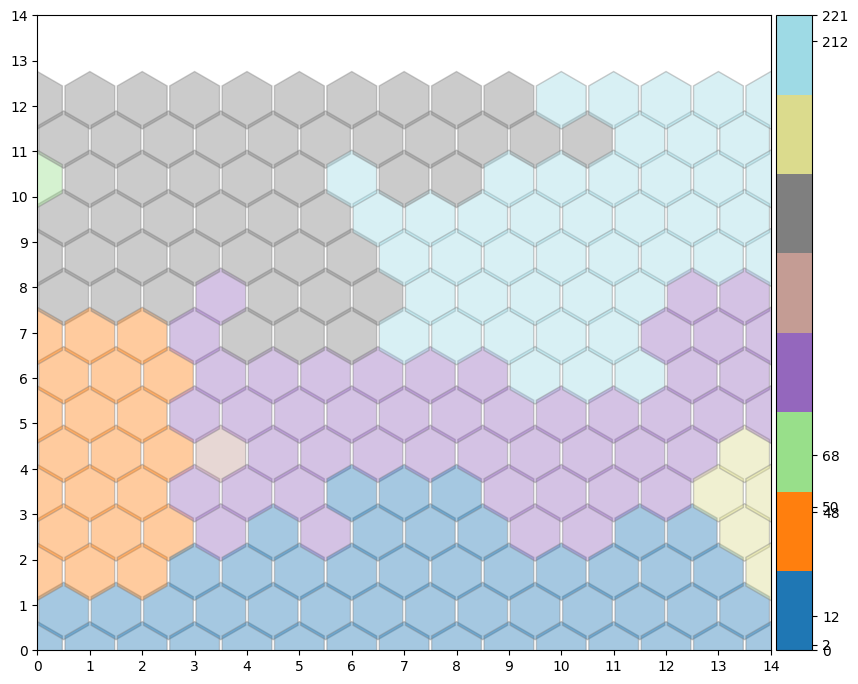

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'segments' is your 2D array where each neuron has a cluster label
# Example: segments = np.random.randint(0, 8, (20, 20))

# Create a colormap for the clusters
unique_segments = np.unique(segments)
cmap = cm.get_cmap('tab20', len(unique_segments))  # Use a colormap with enough colors for clusters

# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        
        # Get the cluster of the current neuron
        cluster = segments[i, j]
        
        # Use the cluster label to get a color from the colormap
        hex_color = cmap(np.where(unique_segments == cluster)[0][0])
        
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=hex_color,  # Color by cluster
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

# Set the axis range and labels
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange - .5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

# Optional: Add color bar for clusters
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

# Create a color bar with the unique clusters
norm = plt.Normalize(vmin=min(unique_segments), vmax=max(unique_segments))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=ax_cb, ticks=unique_segments)

plt.show()

<Axes: >

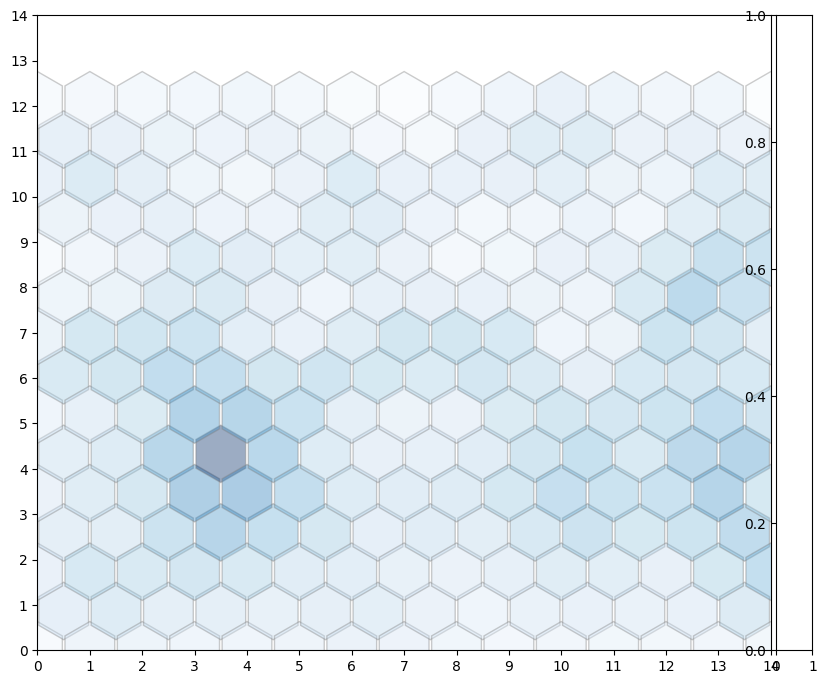

In [22]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

Start mapping cells to neurons

In [24]:
train_embeddings_subset
x = train_embeddings_subset[0,]
w = som.winner(x)
print(w)

(np.int64(4), np.int64(12))
